In [1]:
import numpy as np
import pandas as pd
import datetime
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
import warnings
import os
import time
warnings.filterwarnings('ignore')
np.random.seed(4590)
pd.set_option('max_columns', None)

In [2]:
input_dir = os.path.join('..', 'input')
file_csv = [file for file in os.listdir(input_dir)\
            if file.endswith('.csv')]
print(file_csv)

['historical_transactions.csv', 'merchants.csv', 'new_merchant_transactions.csv', 'sample_submission.csv', 'train.csv', 'test.csv']


In [3]:
## Pandas@reduce dataframe memory
def reduce_mem_usage(props, fillna=False, fillval=None):
    print('[*]Start')
    start_mem_usg = round(props.memory_usage().sum() / 1024**2, 2)
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            # Print current column type
            print("Column: ", col)
            before_type = props[col].dtype
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                if not fillna:
                    print('>>skip {} cause of NA value'.format(col))
                    continue
                NAlist.append(col)
                props[col].fillna(fillval,inplace=True)  
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < pow(2, 8)-1:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < pow(2, 16)-1:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < pow(2, 32)-1:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)    
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)
            # Print new column type
            after_type = props[col].dtype
            print(">>dtype : {} -> {}".format(before_type, after_type))
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = round(props.memory_usage().sum() / 1024**2, 2) 
    percent = round(100*mem_usg/start_mem_usg, 2)
    print("Memory usage : {}MB -> {}MB ({}% decrease)".format(start_mem_usg, mem_usg, percent))
    return props, NAlist

In [4]:
def read_data(fillna=False, fillval=-999):
    df_train = pd.read_csv(os.path.join(input_dir, 'train.csv'))
    df_test = pd.read_csv(os.path.join(input_dir, 'test.csv'))
    df_hist_trans = pd.read_csv(os.path.join(input_dir, 'historical_transactions.csv'))
    #df_new_merchant_trans = pd.read_csv(os.path.join(input_dir, 'new_merchant_transactions.csv'))
    df_train, _ = reduce_mem_usage(df_train, fillna=fillna, fillval=fillval)
    df_test, _ = reduce_mem_usage(df_test, fillna=fillna, fillval=fillval)
    df_hist_trans, _ = reduce_mem_usage(df_hist_trans, fillna=fillna, fillval=fillval)
    #df_new_merchant_trans, _ = reduce_mem_usage(df_new_merchant_trans, fillna=False, fillval=-999)
    return df_train, df_test, df_hist_trans

In [5]:
#fill nan value
def fill_nan_val(df):
    df['category_2'].fillna(1.0, inplace=True)
    df['category_3'].fillna('None', inplace=True)
    df['merchant_id'].fillna('None', inplace=True)

def fix_date(df):
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['purchase_year'] = df['purchase_date'].dt.year
    df['purchase_month'] = df['purchase_date'].dt.month
    df['weekofyear'] = df['purchase_date'].dt.weekofyear
    df['dayofweek'] = df['purchase_date'].dt.dayofweek
    df['weekend'] = (df.purchase_date.dt.weekday >=5).astype(int)
    
def fix_category(df):
    df['authorized_flag'] = df['authorized_flag'].map({'Y':1, 'N':0})
    df['category_1'] = df['category_1'].map({'Y':1, 'N':0}) 
    df['category_3'] = df['category_3'].map({'A':0, 'B':1, 'C':2, 'None':3})
    
def fix_others(df):
    #transform to datetime
    df['purchase_amount'] = np.log1p(df['purchase_amount'])

def fix_transactions(df):
    fill_nan_val(df)
    fix_date(df)
    fix_category(df)
    fix_others(df)
    
def fix_train(df):
    #transform to datetime
    df['first_active_date'] = pd.to_datetime(df['first_active_month'])
    df['first_active_year'] = df['first_active_date'].dt.year
    df['first_active_month'] = df['first_active_date'].dt.month

In [6]:
def get_base_date(df):
    df = df[['card_id', 'month_lag', 'purchase_date']].copy()
    df = df.sort_values(by='purchase_date')
    #get max purchase_date
    df_max = df.groupby(['card_id']).tail(1)
    df_max.columns = ['card_id', 'month_lag', 'purchase_date_max']
    #get basement date
    df_max['month_lag'] = pd.to_timedelta(df_max['month_lag'], unit='M')
    df_max['base_purchase_date'] = df_max['purchase_date_max'] - df_max['month_lag']
    df_max['base_purhcase_date_year'] = df_max['base_purchase_date'].dt.year
    df_max['base_purhcase_date_month'] = df_max['base_purchase_date'].dt.month
    #get min purchase_date
    df_min = df[['card_id', 'purchase_date']].groupby(['card_id']).first().reset_index()
    df_min.columns = ['card_id', 'purchase_date_min']
    #merge data
    df = pd.merge(df_max, df_min, on=['card_id'], how='left')
    df = df.drop(['month_lag'], axis=1)
    return df

def get_period(df):
    #first active <-> purchase_date min
    df['period_first_to_min'] = (df['purchase_date_min'] - df['first_active_date']).dt.days // 30
    #purchase_date min <-> purchase_date max
    df['period_min_to_max'] = (df['purchase_date_max'] - df['purchase_date_min']).dt.days
    #purchase_date_max <-> basement date
    df['period_max_to_base'] = (df['base_purchase_date'] - df['purchase_date_max']).dt.days // 30
    return df

def add_base_date(train, test, trans):
    df = get_base_date(trans)
    train = pd.merge(train, df, on=['card_id'], how='left')
    test = pd.merge(test, df, on=['card_id'], how='left')
    train = get_period(train)
    test = get_period(test)
    return train, test

In [7]:
def get_purchase_interval(train, test, trans):
    train_test = pd.concat([df_train[['card_id', 'first_active_date']], df_test[['card_id', 'first_active_date']]])
    trans = pd.merge(trans, train_test, on=['card_id'], how='left')
    trans['purchase_interval'] = (trans.purchase_date - trans.first_active_date).dt.days // 30
    return trans

In [8]:
def get_lag_rate_features(df):
    df = df[['card_id', 'month_lag', 'purchase_amount']].copy()
    lag_features = df.groupby(['card_id', 'month_lag']).aggregate({'purchase_amount':['size', 'mean', 'sum']}).unstack()
    new_cols = []
    for x in lag_features.columns:
        new_cols.append('_'.join([str(a) for a in x]))
        
    lag_features.columns = new_cols
    lag_features.fillna(0, inplace=True)
    lag_features = lag_features.drop_duplicates()
    
    rate_col_name = 'rate_{}_{}_{}'
    month_mean_col_name = 'purchase_amount_{}_{}'
    for col in ['size', 'mean', 'sum']:
        for month in range(0, -13, -1):
            before_col = month_mean_col_name.format(col, month)
            after_col = month_mean_col_name.format(col, month - 1)
            lag_features[rate_col_name.format(month, month-1, col)] = lag_features[after_col] / lag_features[before_col]
    
    size_cols = [x for x in lag_features.columns if 'size' in x]
    mean_cols = [x for x in lag_features.columns if 'mean' in x]
    std_cols = [x for x in lag_features.columns if 'sum' in x]
    
    for name, cols in zip(['size', 'mean', 'sum'], [size_cols, mean_cols, std_cols]):
        for col, func in zip(['mean', 'std', 'sum'], [np.mean, np.std, np.sum]):
            col_name = 'rate_{}_{}'.format(name, col)
            lag_features[col_name] = np.log1p(lag_features[cols].apply(lambda x: func([rate for rate in x if -np.inf<rate<np.inf]), axis=1))
    '''
    lag_features['rate_size_mean'] = lag_features[size_cols].apply(lambda x: np.mean([rate for rate in x if -np.inf<rate<np.inf]), axis=1)
    lag_features['rate_size_std'] = lag_features[size_cols].apply(lambda x: np.std([rate for rate in x if -np.inf<rate<np.inf]), axis=1)
    lag_features['rate_size_sum'] = lag_features[size_cols].apply(lambda x: np.sum([rate for rate in x if -np.inf<rate<np.inf]), axis=1)
    lag_features['rate_mean_mean'] = lag_features[mean_cols].apply(lambda x: np.mean([rate for rate in x if -np.inf<rate<np.inf]), axis=1)
    lag_features['rate_mean_std'] = lag_features[mean_cols].apply(lambda x: np.std([rate for rate in x if -np.inf<rate<np.inf]), axis=1)
    lag_features['rate_mean_sum'] = lag_features[mean_cols].apply(lambda x: np.sum([rate for rate in x if -np.inf<rate<np.inf]), axis=1)
    lag_features['rate_sum_mean'] = lag_features[std_cols].apply(lambda x: np.mean([rate for rate in x if -np.inf<rate<np.inf]), axis=1)
    lag_features['rate_sum_std'] = lag_features[std_cols].apply(lambda x: np.std([rate for rate in x if -np.inf<rate<np.inf]), axis=1)
    lag_features['rate_sum_sum'] = lag_features[std_cols].apply(lambda x: np.sum([rate for rate in x if -np.inf<rate<np.inf]), axis=1)
    '''
    
    return lag_features[['rate_size_mean', 'rate_size_std', 'rate_size_sum',
                         'rate_mean_mean', 'rate_mean_std', 'rate_mean_sum',
                         'rate_sum_mean', 'rate_sum_std', 'rate_sum_sum']]

def add_lag_rate_features(train, test, trans):
    lag_features = get_lag_rate_features(trans)
    train = pd.merge(train, lag_features, on=['card_id'], how='left')
    test = pd.merge(test, lag_features, on=['card_id'], how='left')
    return train, test

In [9]:
def get_aggregate_features(trans):
    #https://www.kaggle.com/gpreda/elo-world-high-score-without-blending
    def get_new_columns(name,aggs):
        return [name + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]
    
    aggs = {}
    #date features
    for col in ['purchase_month','purchase_year', 'weekofyear','dayofweek']:
        aggs[col] = ['nunique']
    #id features
    for col in ['city_id','state_id', 'subsector_id', 'merchant_category_id', 'merchant_id']:
        aggs[col] = ['nunique']
        
    aggs['purchase_amount'] = ['max', 'min','mean', 'sum', 'var', 'std', 'nunique']
    aggs['installments'] = ['max','min','mean', 'sum', 'var', 'std']
    aggs['month_lag'] = ['max','min', 'mean', 'nunique']
    aggs['authorized_flag'] = ['mean', 'sum', 'std', 'var']
    aggs['card_id'] = ['size']
    aggs['purchase_interval'] = ['mean', 'min', 'max', 'std', 'var']
    aggs['category_1'] = ['mean', 'sum', 'nunique']
    aggs['category_2'] = ['mean', 'sum', 'nunique']
    aggs['category_3'] = ['mean', 'sum', 'nunique']
    '''
    for col in ['category_2','category_3']:
        trans[col+'_mean'] = trans.groupby([col])['purchase_amount'].transform('mean')
        trans[col+'_min'] = trans.groupby([col])['purchase_amount'].transform('min')
        trans[col+'_max'] = trans.groupby([col])['purchase_amount'].transform('max')
        trans[col+'_sum'] = trans.groupby([col])['purchase_amount'].transform('sum')
        trans[col+'_std'] = trans.groupby([col])['purchase_amount'].transform('std')
        aggs[col+'_mean'] = ['mean']
    '''
    new_columns = get_new_columns('hist',aggs)
    df_hist_trans_group = trans.groupby('card_id').agg(aggs)
    df_hist_trans_group.columns = new_columns
    df_hist_trans_group.reset_index(drop=False,inplace=True)
    
    return df_hist_trans_group

def add_aggregate_features(train, test, trans):
    df_hist_trans_group = get_aggregate_features(trans)
    train = pd.merge(train, df_hist_trans_group, on=['card_id'], how='left')
    test = pd.merge(test, df_hist_trans_group, on=['card_id'], how='left')
    return train, test

In [10]:
def add_additional_features(df):
    df['avg_purchase_amount_per_period'] = df['hist_purchase_amount_sum'] / df['period_min_to_max']
    df['avg_size_per_period'] = df['hist_card_id_size'] / df['period_min_to_max']
    
    return df

In [11]:
def add_outliers(df):
    df['outliers'] = 0
    df.loc[df['target'] < -30, 'outliers'] = 1

In [12]:
def get_time(start):
    return round(time.time() - start, 2)

In [13]:
def get_data(df_train, df_test, df_hist_trans, lag_features=False):
    print('[*]Start preprocessing')
    start = time.time()
    fix_transactions(df_hist_trans)
    fix_train(df_train)
    fix_train(df_test)
    print('[{:>6}s]Fix data'.format(get_time(start)))

    start = time.time()
    df_hist_trans = get_purchase_interval(df_train, df_test, df_hist_trans)
    print('[{:>6}s]Fix add trans features'.format(get_time(start)))

    start = time.time()
    df_train, df_test = add_base_date(df_train, df_test, df_hist_trans)
    print('[{:>6}s]Add base date'.format(get_time(start)))
    
    if lag_features:
        start = time.time()
        df_train, df_test = add_lag_rate_features(df_train, df_test, df_hist_trans)
        print('[{:>6}s]Add lag features'.format(get_time(start)))

    start = time.time()
    df_train, df_test = add_aggregate_features(df_train, df_test, df_hist_trans)
    print('[{:>6}s]Add aggregate features'.format(get_time(start)))

    start = time.time()
    df_train = add_additional_features(df_train)
    df_test = add_additional_features(df_test)
    print('[{:>6}s]Add additional features'.format(get_time(start)))

    start = time.time()
    add_outliers(df_train)
    print('[{:>6}s]Add outliers_features'.format(get_time(start)))

    gc.collect()
    
    return df_train, df_test

In [14]:
start = time.time()
df_train, df_test, df_hist_trans = read_data()
print('[{:>6}s]Read data'.format(get_time(start)))

[*]Start
Column:  feature_1
>>dtype : int64 -> uint8
Column:  feature_2
>>dtype : int64 -> uint8
Column:  feature_3
>>dtype : int64 -> uint8
Column:  target
>>dtype : float64 -> float32
___MEMORY USAGE AFTER COMPLETION:___
Memory usage : 9.24MB -> 4.43MB (47.94% decrease)
[*]Start
Column:  feature_1
>>dtype : int64 -> uint8
Column:  feature_2
>>dtype : int64 -> uint8
Column:  feature_3
>>dtype : int64 -> uint8
___MEMORY USAGE AFTER COMPLETION:___
Memory usage : 4.72MB -> 2.24MB (47.46% decrease)
[*]Start
Column:  city_id
>>dtype : int64 -> int16
Column:  installments
>>dtype : int64 -> int16
Column:  merchant_category_id
>>dtype : int64 -> int16
Column:  month_lag
>>dtype : int64 -> int8
Column:  purchase_amount
>>dtype : float64 -> float32
Column:  category_2
>>skip category_2 cause of NA value
Column:  state_id
>>dtype : int64 -> int8
Column:  subsector_id
>>dtype : int64 -> int8
___MEMORY USAGE AFTER COMPLETION:___
Memory usage : 3109.54MB -> 1915.7MB (61.61% decrease)
[ 40.53s]Read

In [15]:
lag_features = True
df_train, df_test = get_data(df_train, df_test, df_hist_trans,
                             lag_features=lag_features)

print('[*]df_train : {}'.format(df_train.shape))
print('[*]df_test : {}'.format(df_test.shape))

[*]Start preprocessing
[ 15.71s]Fix data
[  7.79s]Fix add trans features
[ 24.51s]Add base date
[ 88.33s]Add lag features
[143.26s]Add aggregate features
[   0.0s]Add additional features
[  0.03s]Add outliers_features
[*]df_train : (201917, 73)
[*]df_test : (123623, 71)


In [16]:
df_train.head(10)

,first_active_month,card_id,feature_1,feature_2,feature_3,target,first_active_date,first_active_year,purchase_date_max,base_purchase_date,base_purhcase_date_year,base_purhcase_date_month,purchase_date_min,period_first_to_min,period_min_to_max,period_max_to_base,rate_size_mean,rate_size_std,rate_size_sum,rate_mean_mean,rate_mean_std,rate_mean_sum,rate_sum_mean,rate_sum_std,rate_sum_sum,hist_subsector_id_nunique,hist_dayofweek_nunique,hist_installments_max,hist_installments_min,hist_installments_mean,hist_installments_sum,hist_installments_var,hist_installments_std,hist_month_lag_max,hist_month_lag_min,hist_month_lag_mean,hist_month_lag_nunique,hist_card_id_size,hist_city_id_nunique,hist_category_1_mean,hist_category_1_sum,hist_category_1_nunique,hist_weekofyear_nunique,hist_purchase_month_nunique,hist_category_3_mean,hist_category_3_sum,hist_category_3_nunique,hist_purchase_interval_mean,hist_purchase_interval_min,hist_purchase_interval_max,hist_purchase_interval_std,hist_purchase_interval_var,hist_merchant_id_nunique,hist_authorized_flag_mean,hist_authorized_flag_sum,hist_authorized_flag_std,hist_authorized_flag_var,hist_purchase_year_nunique,hist_merchant_category_id_nunique,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_mean,hist_purchase_amount_sum,hist_purchase_amount_var,hist_purchase_amount_std,hist_purchase_amount_nunique,hist_category_2_mean,hist_category_2_sum,hist_category_2_nunique,hist_state_id_nunique,avg_purchase_amount_per_period,avg_size_per_period,outliers
0,6,C_ID_92a2005557,5,2,1,-0.820283,2017-06-01,2017,2018-02-25 09:31:15,2018-02-25 09:31:15,2018,2,2017-06-27 14:18:08,0,242,0,2.542380,2.897813,5.599634,-0.079641,0.645757,NaN,NaN,2.986953,NaN,21,7,1,0,0.015385,4,0.015206,0.123314,0,-8,-3.911538,9,260,7,0.000000,0,1,35,9,0.015385,4,2,4.184615,0.0,8.0,2.451962,6.012118,95,0.950000,247,0.218365,0.047683,2,41,1.181235,-1.344748,-1.076957,-280.008759,0.084635,0.290922,209,1.046154,272.0,2,3,-1.157061,1.074380,0
1,1,C_ID_3d0044924f,4,1,0,0.392913,2017-01-01,2017,2018-01-31 22:31:09,2018-01-31 22:31:09,2018,1,2017-01-06 16:29:42,0,390,0,2.671841,2.828358,5.898794,-0.047530,0.677368,NaN,NaN,2.992090,NaN,24,7,10,-1,1.551429,543,2.282448,1.510777,0,-12,-5.031429,13,350,9,0.088571,31,2,50,12,1.217143,426,3,7.088571,0.0,13.0,3.929994,15.444855,142,0.968571,339,0.174723,0.030528,2,57,1.728163,-1.356347,-1.051759,-368.115631,0.173675,0.416743,234,1.000000,350.0,1,3,-0.943886,0.897436,0
2,8,C_ID_d639edf6cd,2,2,0,0.688056,2016-08-01,2016,2018-02-27 19:08:25,2018-02-27 19:08:25,2018,2,2017-01-11 08:21:22,5,412,0,1.142067,1.144321,3.995094,-0.178574,0.703992,NaN,NaN,1.412763,NaN,7,7,0,0,0.000000,0,0.000000,0.000000,0,-13,-8.604651,12,43,5,0.000000,0,1,22,10,0.000000,0,1,9.604651,5.0,19.0,4.036379,16.292359,13,0.953488,41,0.213083,0.045404,2,8,-0.157645,-1.309845,-1.154313,-49.635452,0.031422,0.177264,41,4.627907,199.0,2,2,-0.120474,0.104369,0
3,9,C_ID_186d6a6901,4,3,0,0.142495,2017-09-01,2017,2018-02-28 11:44:40,2018-02-28 11:44:40,2018,2,2017-09-26 16:22:21,0,154,0,1.651779,2.140342,4.446468,-0.042152,0.609226,-1.745936,NaN,2.341905,NaN,13,7,3,-1,1.090909,84,0.346890,0.588974,0,-5,-2.831169,6,77,7,0.155844,12,2,20,6,1.142857,88,3,2.207792,0.0,6.0,1.837745,3.377307,50,1.000000,77,0.000000,0.000000,2,25,0.894289,-1.350530,-1.117095,-86.016327,0.112532,0.335458,72,3.064935,236.0,2,5,-0.558548,0.500000,0
4,11,C_ID_cdbd2c0db2,1,3,0,-0.159749,2017-11-01,2017,2018-02-28 20:40:41,2018-02-28 20:40:41,2018,2,2017-11-12 00:00:00,0,108,0,2.144407,2.733195,4.917537,-0.009485,0.505941,-0.186233,NaN,2.704938,NaN,17,7,12,1,1.368421,182,3.598086,1.896862,0,-3,-1.285714,4,133,6,0.112782,15,2,17,4,1.052632,140,2,1.736842,0.0,3.0,1.043702,1.089314,67,0.962406,128,0.190931,0.036455,2,26,2.103285,-1.371037,-0.921201,-122.519783,0.422508,0.650006,124,3.443609,458.0,3,6,-1.134442,1.231481,0
5,9,C_ID_0894217f2f,4,2,0,0.871585,2016-09-01,2016,2017-07-29 15:37:18,2017-07-29 15:37:18,2017,7,2017-01-10 17:14:53,4,199,0,1.101166

In [23]:
len([x for x in df_train.columns if 'hist' in x])

45

<br/>
not used --> 7<br/>
card_id / first_active_date / purchase_date_max / base_purchase_date / purchase_date_min / outliers / target (7)<br/>
<br/>
feature columns ==> 3<br/>
feature_1 / feature_2 / feature_3 -> feature_1 / feature_2 / feature_3 (3)<br/>
<br/>
date column ==> 7<br/>
first_active_month -> first_active_year, first_active_month (2)<br/>
base_purchase_date_year, base_purchase_date_month (2)<br/>
period_first_to_min / period_min_to_max / period_max_to_base (3)<br/>
<br/>
rate columns ==> 9<br/>
month_lag -> rate ... (9)<br/>
<br/>
hist_cols ==> 45<br/>
'purchase_month','purchase_year', 'weekofyear','dayofweek' -> nunique (4)<br/>
'city_id','state_id', 'subsector_id', 'merchant_category_id', 'merchant_id' -> nunique (5)<br/>
purchase_amount = 'max', 'min','mean', 'sum', 'var', 'std', 'nunique' (7)<br/>
installments = 'max','min','mean', 'sum', 'var', 'std' (6)<br/>
'month_lag' = 'max','min', 'mean', 'nunique' (4)<br/>
'authorized_flag' = 'mean', 'sum', 'std', 'var' (4)<br/>
'card_id' = 'size'(1)<br/>
'purchase_interval' = 'mean', 'min', 'max', 'std', 'var' (5)<br/>
'category_1' = 'mean', 'sum', 'nunique' (3)<br/>
'category_2' = 'mean', 'sum', 'nunique' (3)<br/>
'category_3' = 'mean', 'sum', 'nunique' (3)<br/>
<br/>
avg columns -> (2)<br/>
<br/>
total ==> 73<br/>



In [17]:
useless_columns = list(df_train.select_dtypes(include=[np.datetime64, object]).columns.values)
useless_columns.extend(['target', 'outliers'])
useless_columns.extend(['rate_size_mean', 'rate_size_std', 'rate_size_sum',
                         'rate_mean_mean', 'rate_mean_sum',
                         'rate_sum_mean', 'rate_sum_sum'])
df_train_columns = [c for c in df_train.columns if c not in useless_columns]
target = df_train['target']
print('[*]Use columns : {}'.format(len(df_train_columns)))
#fig = plt.figure(figsize=(20, 20))
#sns.heatmap(df_train[df_train_columns].corr())

[*]Use columns : 59


In [18]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4590}

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()
for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)
    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits
print('[*]Final score: {}'.format(np.sqrt(mean_squared_error(oof, target))))


fold 0
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[488]	training's rmse: 3.56638	valid_1's rmse: 3.75896
fold 1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[499]	training's rmse: 3.57587	valid_1's rmse: 3.72469
fold 2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[620]	training's rmse: 3.54493	valid_1's rmse: 3.75199
fold 3
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[404]	training's rmse: 3.59293	valid_1's rmse: 3.73149
fold 4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[342]	training's rmse: 3.60468	valid_1's rmse: 3.73673
[*]Final score: 3.7407952838061145


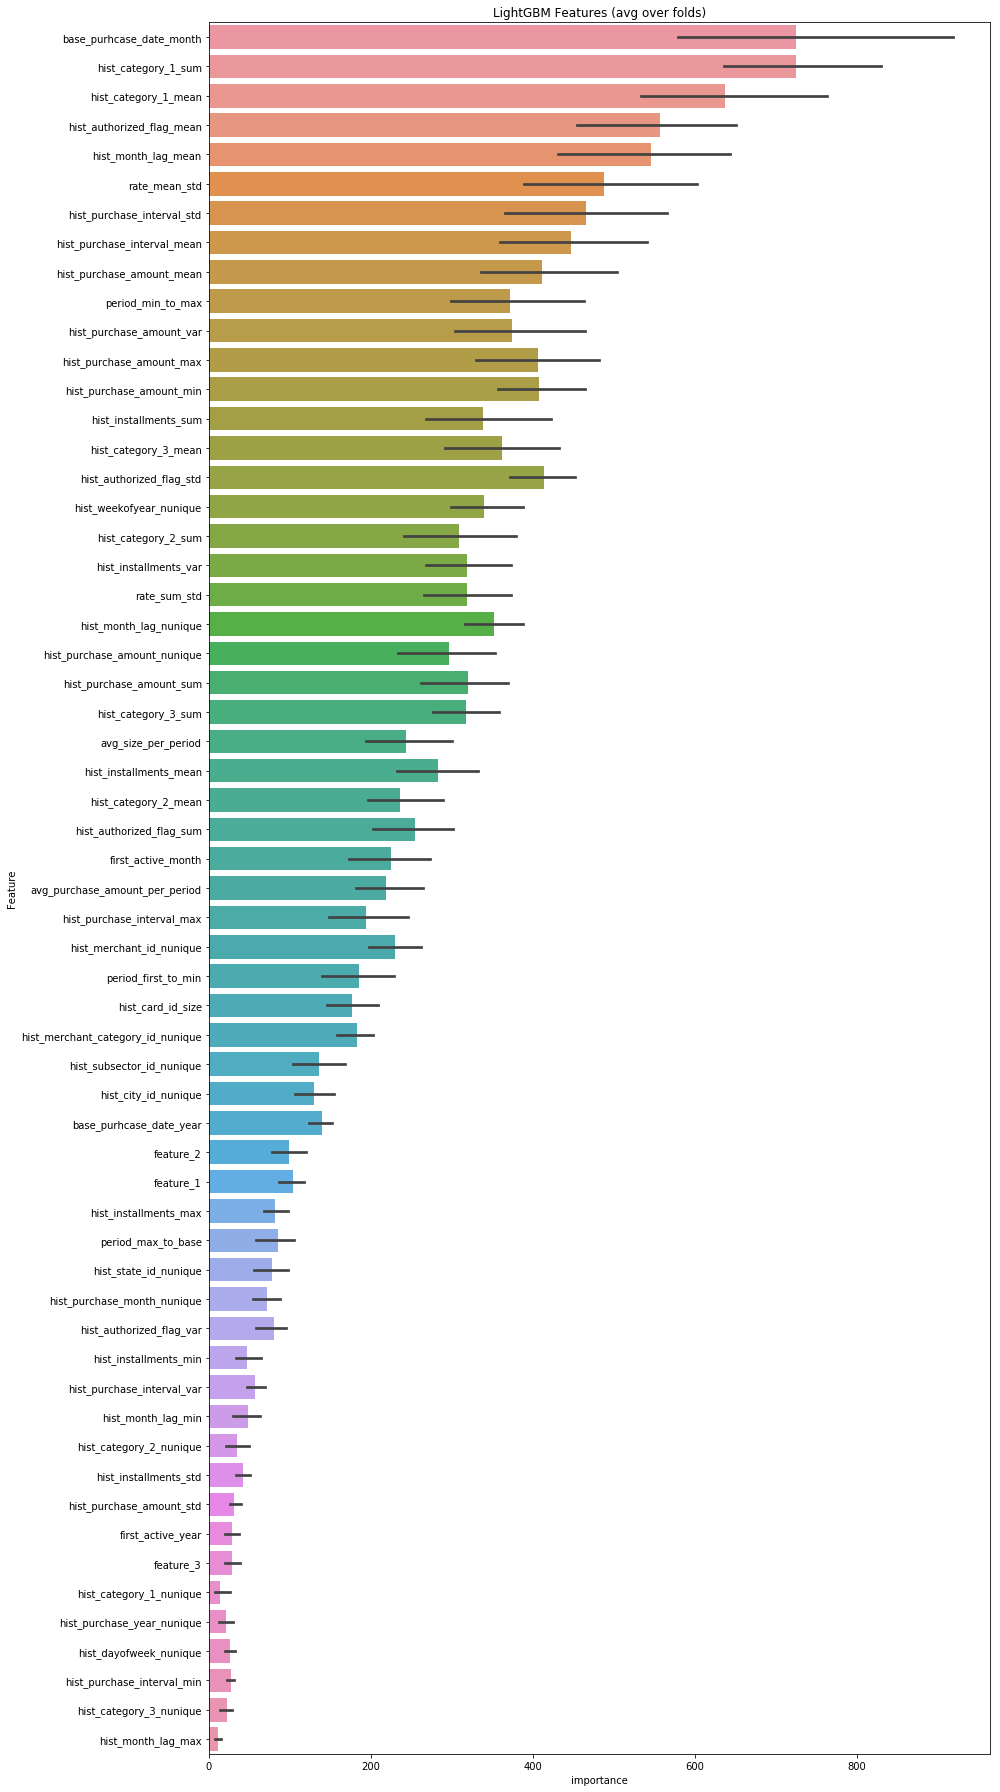

In [21]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
#plt.savefig('lgbm_importances.png')